In [5]:
!pip install transformers datasets nltk wordcloud matplotlib seaborn torch evaluate rouge-score scikit-learn sentencepiece sumy

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [7]:
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✅ All NLTK data downloaded successfully!")

✅ All NLTK data downloaded successfully!


In [8]:
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import evaluate
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [9]:
df = pd.read_csv('/content/Reviews.csv')
print(f"✅ Dataset loaded successfully! Shape: {df.shape}")

✅ Dataset loaded successfully! Shape: (568454, 10)


In [10]:
print(f"Dataset shape: {df.shape}")
df = df.dropna(subset=['Text', 'Summary'])
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape: (568454, 10)
Dataset shape after cleaning: (568427, 10)


In [11]:
# **Comprehensive Data Analysis**
print("\n📊 DATASET ANALYSIS:")
print(f"Total reviews: {len(df):,}")
print(f"Average text length: {df['Text'].str.len().mean():.2f} characters")
print(f"Average summary length: {df['Summary'].str.len().mean():.2f} characters")


📊 DATASET ANALYSIS:
Total reviews: 568,427
Average text length: 436.24 characters
Average summary length: 23.45 characters



📊 DATASET ANALYSIS AND VISUALIZATIONS:


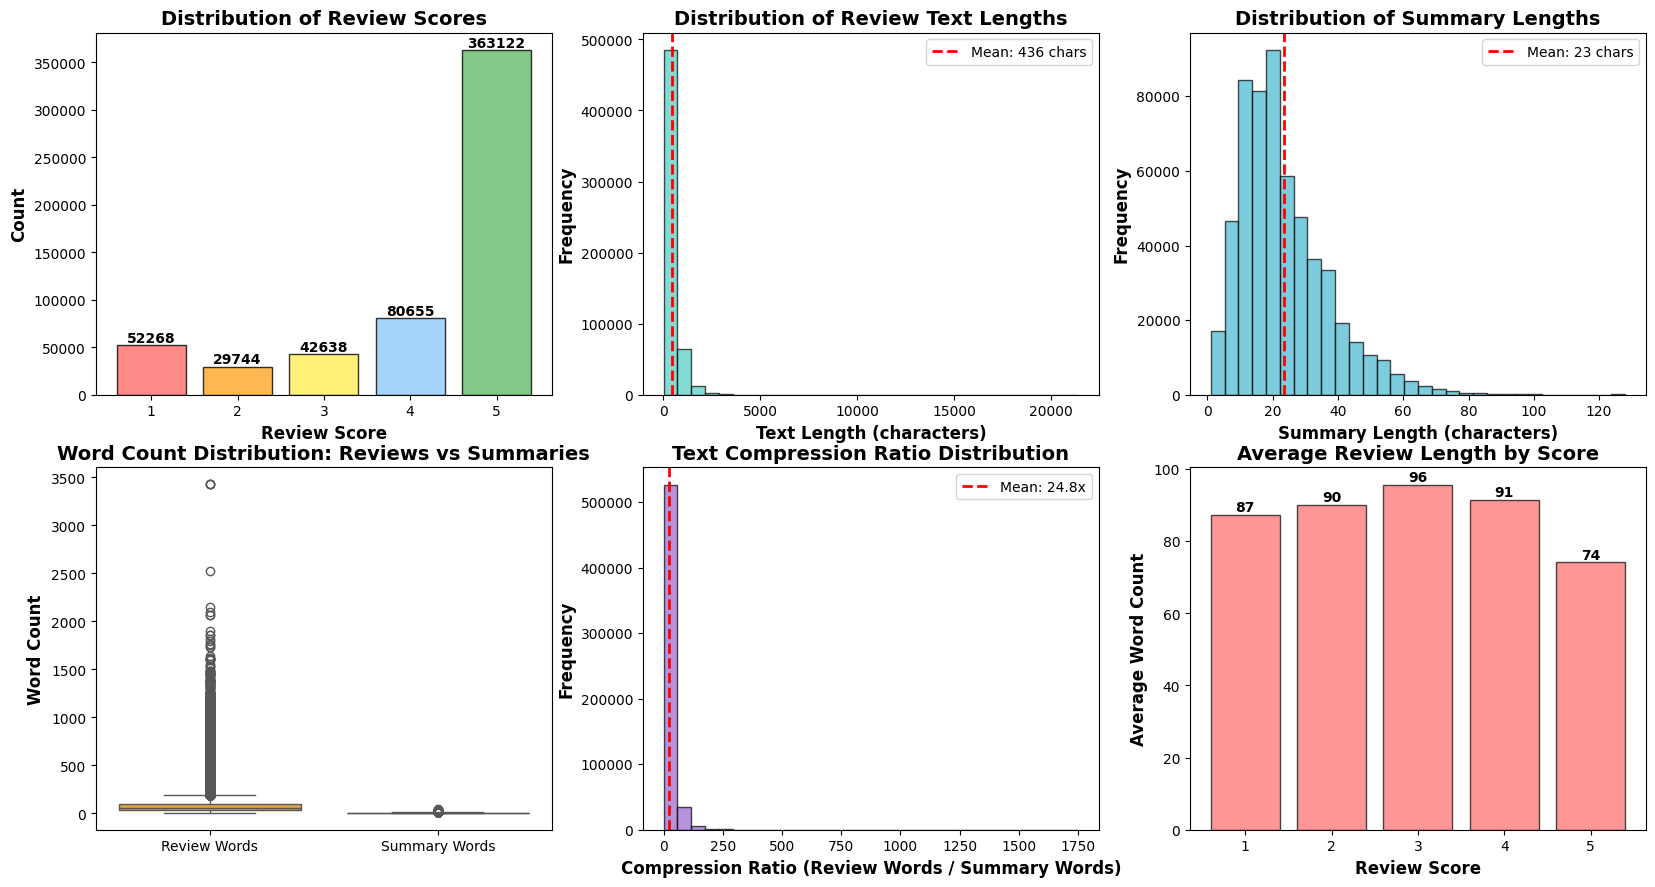

In [12]:
print("\n📊 DATASET ANALYSIS AND VISUALIZATIONS:")
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 3, figure=fig)

# 1. Score Distribution
ax1 = fig.add_subplot(gs[0, 0])
score_counts = df['Score'].value_counts().sort_index()
colors = ['#ff6b6b', '#ffa726', '#ffee58', '#90caf9', '#66bb6a']
bars = ax1.bar(score_counts.index, score_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Review Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Review Scores', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 6))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Text Length Distribution
ax2 = fig.add_subplot(gs[0, 1])
text_lengths = df['Text'].str.len()
ax2.hist(text_lengths, bins=30, alpha=0.7, color='#4ecdc4', edgecolor='black')
ax2.set_xlabel('Text Length (characters)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Review Text Lengths', fontsize=14, fontweight='bold')
ax2.axvline(text_lengths.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {text_lengths.mean():.0f} chars')
ax2.legend()

# 3. Summary Length Distribution
ax3 = fig.add_subplot(gs[0, 2])
summary_lengths = df['Summary'].str.len()
ax3.hist(summary_lengths, bins=30, alpha=0.7, color='#45b7d1', edgecolor='black')
ax3.set_xlabel('Summary Length (characters)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of Summary Lengths', fontsize=14, fontweight='bold')
ax3.axvline(summary_lengths.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {summary_lengths.mean():.0f} chars')
ax3.legend()

# 4. Word Count Analysis
ax4 = fig.add_subplot(gs[1, 0])
df['Text_Word_Count'] = df['Text'].str.split().str.len()
df['Summary_Word_Count'] = df['Summary'].str.split().str.len()

word_counts_data = pd.DataFrame({
    'Review Words': df['Text_Word_Count'],
    'Summary Words': df['Summary_Word_Count']
})

sns.boxplot(data=word_counts_data, ax=ax4, palette=['#ffa726', '#66bb6a'])
ax4.set_ylabel('Word Count', fontsize=12, fontweight='bold')
ax4.set_title('Word Count Distribution: Reviews vs Summaries', fontsize=14, fontweight='bold')

# 5. Compression Ratio
ax5 = fig.add_subplot(gs[1, 1])
compression_ratio = df['Text_Word_Count'] / df['Summary_Word_Count']
ax5.hist(compression_ratio, bins=30, alpha=0.7, color='#9966cc', edgecolor='black')
ax5.set_xlabel('Compression Ratio (Review Words / Summary Words)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax5.set_title('Text Compression Ratio Distribution', fontsize=14, fontweight='bold')
ax5.axvline(compression_ratio.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {compression_ratio.mean():.1f}x')
ax5.legend()

# 6. Score vs Text Length
ax6 = fig.add_subplot(gs[1, 2])
score_text_length = df.groupby('Score')['Text_Word_Count'].mean()
ax6.bar(score_text_length.index, score_text_length.values, color='#ff6b6b', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Review Score', fontsize=12, fontweight='bold')
ax6.set_ylabel('Average Word Count', fontsize=12, fontweight='bold')
ax6.set_title('Average Review Length by Score', fontsize=14, fontweight='bold')
ax6.set_xticks(range(1, 6))

# Add value labels
for i, v in enumerate(score_text_length.values):
    ax6.text(i+1, v + 0.1, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

In [13]:
# Sentence tokenization with error handling
def safe_sentence_count(text):
    try:
        return len(sent_tokenize(str(text)))
    except:
        return 0

print(f"Average sentences per review: {df['Text'].apply(safe_sentence_count).mean():.1f}")

Average sentences per review: 5.0


In [14]:
class TextPreprocessor:
    def __init__(self):
        try:
            self.stop_words = set(stopwords.words('english'))
            self.lemmatizer = WordNetLemmatizer()
        except:
            self.stop_words = set()
            self.lemmatizer = None

    def clean_text(self, text):
        """Clean and preprocess text"""
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s\.\!\?]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def safe_sent_tokenize(self, text):
        """Safe sentence tokenization with error handling"""
        try:
            return sent_tokenize(str(text))
        except:
            return [str(text)] if str(text) else [""]

# **Extractive Summarization**

In [15]:
class ExtractiveSummarizer:
    def __init__(self):
        self.preprocessor = TextPreprocessor()

    def preprocess_text(self, text):
        """Basic text preprocessing"""
        return self.preprocessor.clean_text(text)

    def extract_sentences(self, text):
        """Extract sentences from text with error handling"""
        return self.preprocessor.safe_sent_tokenize(text)

    def evaluate_extractive_summary(self, original_text, generated_summary, reference_summary):
        """Evaluate extractive summary against reference"""
        try:
            original_words = set(self.preprocess_text(original_text).split())
            generated_words = set(self.preprocess_text(generated_summary).split())
            reference_words = set(self.preprocess_text(reference_summary).split())

            # Precision: how many generated words are in reference
            if len(generated_words) > 0:
                precision = len(generated_words.intersection(reference_words)) / len(generated_words)
            else:
                precision = 0

            # Recall: how many reference words are in generated
            if len(reference_words) > 0:
                recall = len(generated_words.intersection(reference_words)) / len(reference_words)
            else:
                recall = 0

            # F1-score
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0

            return {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'word_overlap': len(generated_words.intersection(reference_words))
            }
        except:
            return {'precision': 0, 'recall': 0, 'f1_score': 0, 'word_overlap': 0}

**1. TF-IDF Based Summarizer**

In [52]:
class TFIDFSummarizer(ExtractiveSummarizer):
    def __init__(self):
        super().__init__()
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1, 2))

    def summarize(self, text, num_sentences=3):
        """Enhanced TF-IDF summarization with position weighting"""
        try:
            sentences = self.extract_sentences(text)
            if len(sentences) <= num_sentences:
                return " ".join(sentences)

            preprocessed_sentences = [self.preprocess_text(sent) for sent in sentences]

            # Create TF-IDF matrix
            tfidf_matrix = self.vectorizer.fit_transform(preprocessed_sentences)

            # Calculate sentence scores with position weighting
            sentence_scores = []
            for i, sentence in enumerate(sentences):
                # TF-IDF score
                tfidf_score = tfidf_matrix[i].sum()

                # Position weight (first sentences are often important)
                position_weight = 1.0 / (i + 1) if i < 3 else 0.5

                # Length normalization (prefer medium-length sentences)
                word_count = len(sentence.split())
                length_score = 1.0 if 5 <= word_count <= 25 else 0.5

                # Combined score
                combined_score = tfidf_score * position_weight * length_score
                sentence_scores.append(combined_score)

            sentence_scores = np.array(sentence_scores)

            # Get top N sentences
            top_sentence_indices = sentence_scores.argsort()[-num_sentences:][::-1]
            top_sentences = [sentences[i] for i in sorted(top_sentence_indices)]

            return " ".join(top_sentences)

        except Exception as e:
            return f"Error in Enhanced TF-IDF summarization: {str(e)}"


**2. TextRank Summarizer**

In [70]:
class TextRankSummarizerCustom(ExtractiveSummarizer):
    def __init__(self):
        super().__init__()

    def build_enhanced_similarity_matrix(self, sentences):
        """Enhanced similarity matrix with semantic features"""
        try:
            n = len(sentences)
            similarity_matrix = np.zeros((n, n))

            # Precompute sentence features
            sentence_features = []
            for sentence in sentences:
                words = set(self.preprocess_text(sentence).split())
                # Include bigrams for better semantic understanding
                sentence_words = self.preprocess_text(sentence).split()
                bigrams = set(zip(sentence_words[:-1], sentence_words[1:]))
                sentence_features.append((words, bigrams, len(words)))

            for i in range(n):
                for j in range(n):
                    if i != j:
                        words_i, bigrams_i, len_i = sentence_features[i]
                        words_j, bigrams_j, len_j = sentence_features[j]

                        # Word overlap similarity
                        word_overlap = len(words_i.intersection(words_j))
                        word_union = len(words_i.union(words_j))

                        # Bigram overlap
                        bigram_overlap = len(bigrams_i.intersection(bigrams_j))
                        bigram_union = len(bigrams_i.union(bigrams_j)) if bigrams_i.union(bigrams_j) else 1

                        # Length similarity (penalize very different lengths)
                        length_sim = 1.0 - abs(len_i - len_j) / max(len_i, len_j)

                        if word_union > 0:
                            word_sim = word_overlap / word_union
                            bigram_sim = bigram_overlap / bigram_union

                            # Combined similarity
                            similarity = 0.6 * word_sim + 0.3 * bigram_sim + 0.1 * length_sim
                            similarity_matrix[i][j] = similarity

            return similarity_matrix
        except:
            n = len(sentences)
            return np.ones((n, n)) * 0.1

    def summarize(self, text, num_sentences=3):
        """Enhanced TextRank with better sentence selection"""
        try:
            sentences = self.extract_sentences(text)
            if len(sentences) <= num_sentences:
                return " ".join(sentences)

            # Build enhanced similarity matrix
            similarity_matrix = self.build_enhanced_similarity_matrix(sentences)

            # Convert to graph and calculate pagerank
            nx_graph = nx.from_numpy_array(similarity_matrix)
            scores = nx.pagerank(nx_graph, max_iter=500)

            # Get top sentences with diversity
            ranked_sentences = sorted(((scores[i], i, sent) for i, sent in enumerate(sentences)), reverse=True)

            # Select diverse sentences (avoid picking very similar ones)
            selected_indices = []
            selected_sentences = []

            for score, idx, sentence in ranked_sentences:
                if len(selected_indices) >= num_sentences:
                    break

                # Check if this sentence is too similar to already selected ones
                is_diverse = True
                for selected_idx in selected_indices:
                    if similarity_matrix[idx][selected_idx] > 0.7:  # High similarity threshold
                        is_diverse = False
                        break

                if is_diverse:
                    selected_indices.append(idx)
                    selected_sentences.append(sentence)

            # Sort by original order
            selected_sentences = [sentences[i] for i in sorted(selected_indices)]

            return " ".join(selected_sentences)

        except Exception as e:
            return f"Error in Enhanced TextRank summarization: {str(e)}"

**3. Lead-N Summarizer (Baseline)**

In [71]:
class LeadNSummarizer(ExtractiveSummarizer):
    def summarize(self, text, num_sentences=3):
        """Generate summary by taking first N sentences"""
        try:
            sentences = self.extract_sentences(text)
            return " ".join(sentences[:num_sentences])
        except Exception as e:
            return f"Error in Lead-N summarization: {str(e)}"

**4. Hybrid Summarizer**

In [92]:
class HybridSummarizer(ExtractiveSummarizer):
    def __init__(self):
        super().__init__()
        self.tfidf_summarizer = TFIDFSummarizer()
        self.textrank_summarizer = TextRankSummarizerCustom()

    def summarize(self, text, num_sentences=3):
        """Hybrid approach combining TF-IDF and TextRank"""
        try:
            sentences = self.extract_sentences(text)
            if len(sentences) <= num_sentences:
                return " ".join(sentences)

            # Get scores from both methods
            tfidf_scores = []
            textrank_scores = []

            # TF-IDF scoring
            preprocessed_sentences = [self.preprocess_text(sent) for sent in sentences]
            vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
            tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)
            tfidf_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()

            # TextRank scoring
            similarity_matrix = self.textrank_summarizer.build_enhanced_similarity_matrix(sentences)
            nx_graph = nx.from_numpy_array(similarity_matrix)
            textrank_scores_dict = nx.pagerank(nx_graph)
            textrank_scores = [textrank_scores_dict[i] for i in range(len(sentences))]

            # Normalize scores
            if np.max(tfidf_scores) > 0:
                tfidf_scores = tfidf_scores / np.max(tfidf_scores)
            if np.max(textrank_scores) > 0:
                textrank_scores = textrank_scores / np.max(textrank_scores)

            # Combine scores (equal weighting)
            combined_scores = 0.5 * tfidf_scores + 0.5 * np.array(textrank_scores)

            # Get top sentences
            top_indices = combined_scores.argsort()[-num_sentences:][::-1]
            top_sentences = [sentences[i] for i in sorted(top_indices)]

            return " ".join(top_sentences)

        except Exception as e:
            return f"Error in Hybrid summarization: {str(e)}"

# **Comprehensive Evaluation System**

In [93]:
class ExtractiveSummarizationEvaluator:
    def __init__(self):
        self.rouge = evaluate.load('rouge')

    def evaluate_summarizers(self, test_data, summarizers, num_samples=20):
        """Comprehensive evaluation of multiple summarizers"""
        results = {}

        for name, summarizer in summarizers.items():
            print(f"\n🔍 Evaluating {name}...")
            rouge_scores, detailed_results = self.evaluate_summarizer(
                summarizer, test_data, num_samples
            )
            results[name] = {
                'rouge_scores': rouge_scores,
                'detailed_results': detailed_results
            }

        return results

    def evaluate_summarizer(self, summarizer, test_data, num_samples=20):
        """Evaluate a single summarizer"""
        predictions = []
        references = []
        detailed_results = []

        for i in range(min(num_samples, len(test_data))):
            example = test_data.iloc[i]
            text = example['Text']
            reference_summary = example['Summary']

            # Generate summary
            generated_summary = summarizer.summarize(text)

            predictions.append(generated_summary)
            references.append(reference_summary)

            # Calculate additional metrics
            eval_metrics = summarizer.evaluate_extractive_summary(
                text, generated_summary, reference_summary
            )

            detailed_results.append({
                'text': text[:100] + "..." if len(text) > 100 else text,
                'reference_summary': reference_summary,
                'generated_summary': generated_summary,
                'eval_metrics': eval_metrics
            })

            # Show first few examples
            if i < 2:
                print(f"\n📝 Example {i+1}:")
                print(f"Original: {text[:150]}...")
                print(f"Reference: {reference_summary}")
                print(f"Generated: {generated_summary}")
                print(f"Metrics: P={eval_metrics['precision']:.3f}, R={eval_metrics['recall']:.3f}, F1={eval_metrics['f1_score']:.3f}")
                print("-" * 80)

        # Compute ROUGE scores
        if predictions and references:
            try:
                rouge_scores = self.rouge.compute(
                    predictions=predictions,
                    references=references,
                    use_stemmer=True
                )
                return rouge_scores, detailed_results
            except:
                return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, detailed_results
        else:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, detailed_results

# **Data Preparation**

In [94]:
SAMPLE_SIZE = min(100, len(df))
test_data = df.sample(n=SAMPLE_SIZE, random_state=42)

In [95]:
print(f"Using {len(test_data)} samples for evaluation")

Using 100 samples for evaluation


In [107]:
print("\n🤖 Initializing Extractive Summarizers...")
summarizers = {
    'TF-IDF': TFIDFSummarizer(),
    'TextRank': TextRankSummarizerCustom(),
    'Lead-3 (Baseline)': LeadNSummarizer(),
    'Hybrid': HybridSummarizer()
}
print("✅ All extractive summarizers initialized!")


🤖 Initializing Extractive Summarizers...
✅ All extractive summarizers initialized!


In [108]:
evaluator = ExtractiveSummarizationEvaluator()
results = evaluator.evaluate_summarizers(test_data, summarizers, num_samples=15)


🔍 Evaluating TF-IDF...

📝 Example 1:
Original: These are actually very tasty.  Pure potatoes with a great texture and no nasty filler "stuff."  No bacon, no cheese...just tasty potatoes.  They cook...
Reference: I like these!
Generated: These are actually very tasty. Pure potatoes with a great texture and no nasty filler "stuff." I add a touch of either salt & pepper or fajita seasoning to spice it up.
Metrics: P=0.033, R=0.333, F1=0.061
--------------------------------------------------------------------------------

📝 Example 2:
Original: I realize that taste is a matter of personal preference so food reviews are always going to be hit or miss for your tastes. Got the cookies, liked the...
Reference: Good but subjectively not 5 star
Generated: I realize that taste is a matter of personal preference so food reviews are always going to be hit or miss for your tastes. Got the cookies, liked them but they didn't quite send me the way other folks seem to take to them. Not bad and I don't

# **Results Visualization**

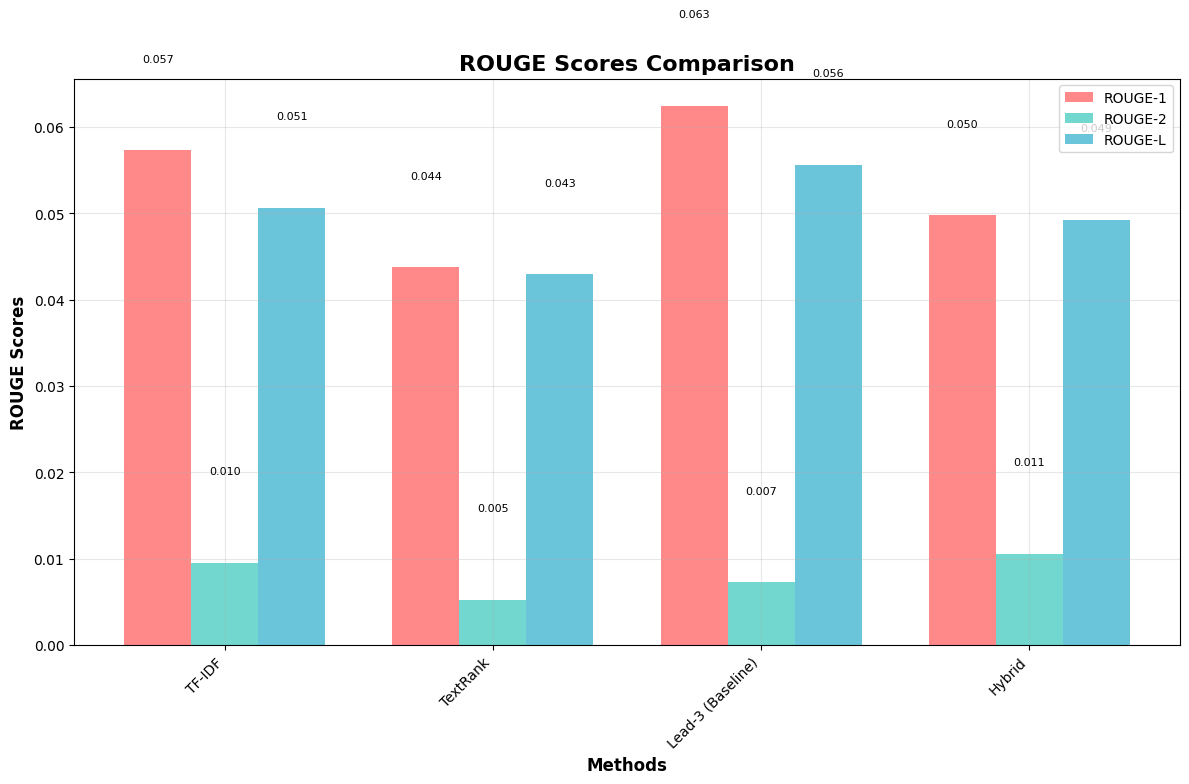

In [109]:
# ROUGE Scores Comparison Graph
plt.figure(figsize=(12, 8))

# Prepare data
methods = list(results.keys())
rouge1_scores = [results[method]['rouge_scores'].get('rouge1', 0) for method in methods]
rouge2_scores = [results[method]['rouge_scores'].get('rouge2', 0) for method in methods]
rougeL_scores = [results[method]['rouge_scores'].get('rougeL', 0) for method in methods]

x = np.arange(len(methods))
width = 0.25

# Create grouped bar chart
plt.bar(x - width, rouge1_scores, width, label='ROUGE-1', alpha=0.8, color='#FF6B6B')
plt.bar(x, rouge2_scores, width, label='ROUGE-2', alpha=0.8, color='#4ECDC4')
plt.bar(x + width, rougeL_scores, width, label='ROUGE-L', alpha=0.8, color='#45B7D1')

# Customize the chart
plt.xlabel('Methods', fontsize=12, fontweight='bold')
plt.ylabel('ROUGE Scores', fontsize=12, fontweight='bold')
plt.title('ROUGE Scores Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, (r1, r2, rL) in enumerate(zip(rouge1_scores, rouge2_scores, rougeL_scores)):
    plt.text(i - width, r1 + 0.01, f'{r1:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, r2 + 0.01, f'{r2:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width, rL + 0.01, f'{rL:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

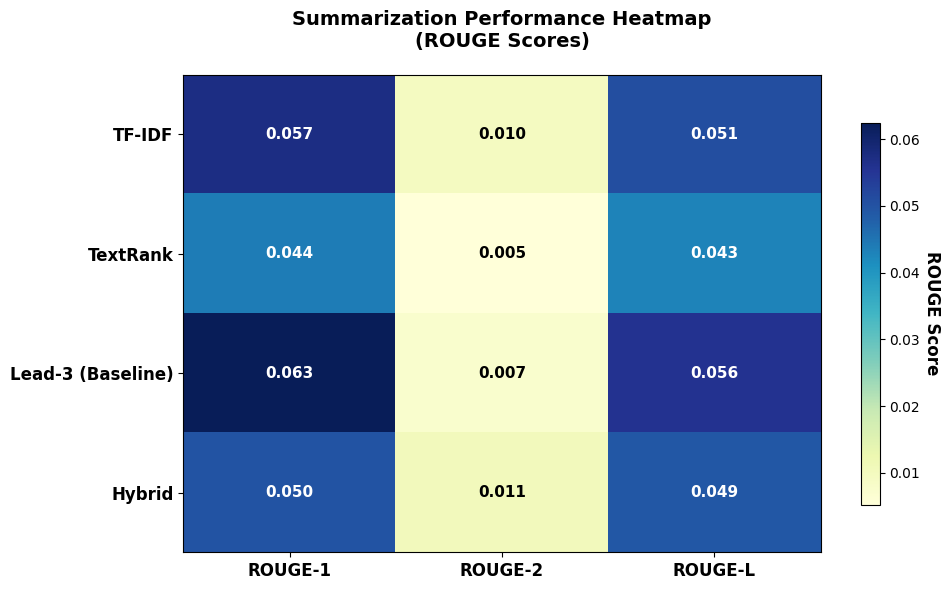

Performance Summary:
                   ROUGE-1  ROUGE-2  ROUGE-L
TF-IDF              0.0573   0.0095   0.0507
TextRank            0.0438   0.0052   0.0430
Lead-3 (Baseline)   0.0625   0.0073   0.0557
Hybrid              0.0498   0.0106   0.0493


In [110]:
# 3. Performance Heatmap
performance_data = []
for method in summarizers.keys():
    performance_data.append([
        results[method]['rouge_scores'].get('rouge1', 0),
        results[method]['rouge_scores'].get('rouge2', 0),
        results[method]['rouge_scores'].get('rougeL', 0)
    ])

performance_df = pd.DataFrame(performance_data,
                             index=summarizers.keys(),
                             columns=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])

plt.figure(figsize=(10, 6))
im = plt.imshow(performance_data, cmap='YlGnBu', aspect='auto')
plt.xticks(range(3), ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], fontsize=12, fontweight='bold')
plt.yticks(range(len(summarizers)), summarizers.keys(), fontsize=12, fontweight='bold')
plt.title('Summarization Performance Heatmap\n(ROUGE Scores)', fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('ROUGE Score', rotation=270, labelpad=15, fontsize=12, fontweight='bold')

# Add values to heatmap
for i in range(len(summarizers)):
    for j in range(3):
        score = performance_data[i][j]
        text_color = 'white' if score > 0.02 else 'black'
        plt.text(j, i, f'{score:.3f}', ha="center", va="center",
                color=text_color, fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("Performance Summary:")
print(performance_df.round(4))

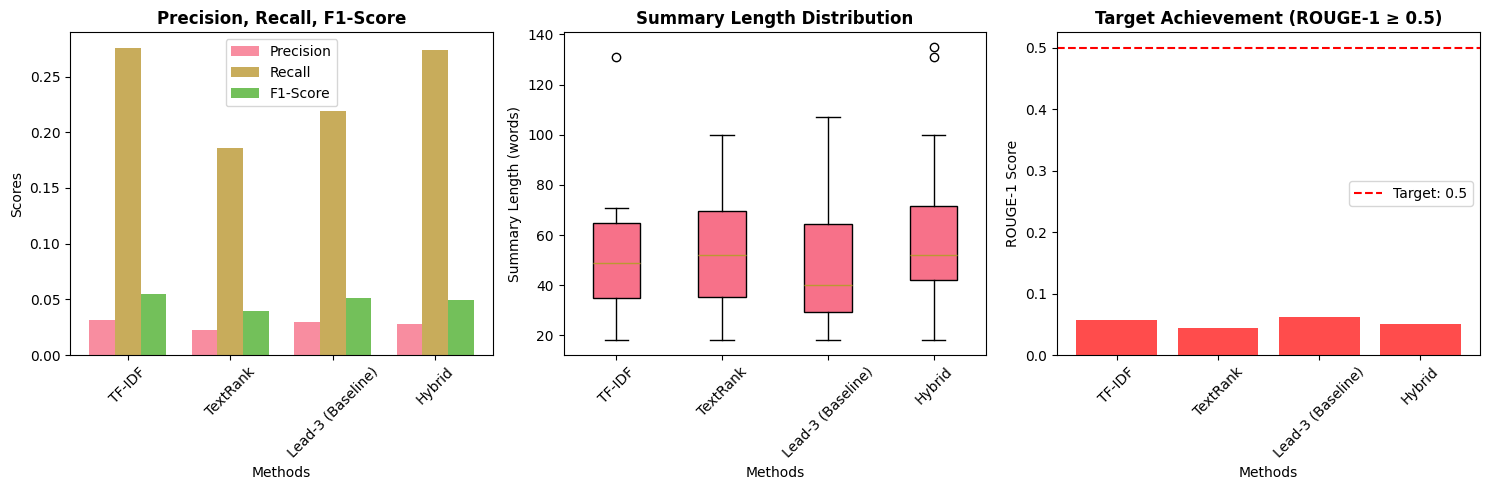

In [111]:
# 4. Summary Quality Metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision, Recall, F1 Comparison
precision_scores = []
recall_scores = []
f1_scores = []

for method in methods:
    detailed_results = results[method]['detailed_results']
    precisions = [r['eval_metrics']['precision'] for r in detailed_results]
    recalls = [r['eval_metrics']['recall'] for r in detailed_results]
    f1s = [r['eval_metrics']['f1_score'] for r in detailed_results]

    precision_scores.append(np.mean(precisions))
    recall_scores.append(np.mean(recalls))
    f1_scores.append(np.mean(f1s))

x = np.arange(len(methods))
width = 0.25

axes[0].bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
axes[0].bar(x, recall_scores, width, label='Recall', alpha=0.8)
axes[0].bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Methods')
axes[0].set_ylabel('Scores')
axes[0].set_title('Precision, Recall, F1-Score', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=45)
axes[0].legend()

# Summary Length Distribution
summary_lengths = []
for method in methods:
    lengths = [len(r['generated_summary'].split()) for r in results[method]['detailed_results']]
    summary_lengths.append(lengths)

box_plot = axes[1].boxplot(summary_lengths, labels=methods, patch_artist=True)
axes[1].set_xlabel('Methods')
axes[1].set_ylabel('Summary Length (words)')
axes[1].set_title('Summary Length Distribution', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Target Achievement
target_rouge = 0.5
achievement = [1 if score >= target_rouge else 0 for score in rouge1_scores]
colors = ['green' if a == 1 else 'red' for a in achievement]

axes[2].bar(methods, rouge1_scores, color=colors, alpha=0.7)
axes[2].axhline(y=target_rouge, color='red', linestyle='--', label=f'Target: {target_rouge}')
axes[2].set_xlabel('Methods')
axes[2].set_ylabel('ROUGE-1 Score')
axes[2].set_title('Target Achievement (ROUGE-1 ≥ 0.5)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

In [122]:
print("\n📊 COMPREHENSIVE RESULTS SUMMARY")

comparison_data = []
for name, result in results.items():
    rouge_scores = result['rouge_scores']
    comparison_data.append({
        'Summarizer': name,
        'ROUGE-1': f"{rouge_scores.get('rouge1', 0):.4f}",
        'ROUGE-2': f"{rouge_scores.get('rouge2', 0):.4f}",
        'ROUGE-L': f"{rouge_scores.get('rougeL', 0):.4f}"
    })

results_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("ROUGE SCORES COMPARISON")
print("="*60)
print(results_df.to_string(index=False))


📊 COMPREHENSIVE RESULTS SUMMARY

ROUGE SCORES COMPARISON
       Summarizer ROUGE-1 ROUGE-2 ROUGE-L
           TF-IDF  0.0573  0.0095  0.0507
         TextRank  0.0438  0.0052  0.0430
Lead-3 (Baseline)  0.0625  0.0073  0.0557
           Hybrid  0.0498  0.0106  0.0493


In [113]:
rouge1_scores = [float(item['ROUGE-L']) for item in comparison_data]
best_rougel = max(rouge1_scores)
best_method = [item['Summarizer'] for item in comparison_data if float(item['ROUGE-L']) == best_rougel][0]
print(f"\n🏆 BEST PERFORMER: {best_method} (ROUGE-L: {best_rougel:.4f})")


🏆 BEST PERFORMER: Lead-3 (Baseline) (ROUGE-L: 0.0557)


In [114]:
if results:
    best_result = results[best_method]

    print(f"\n🔍 DETAILED ANALYSIS: {best_method}")

    # Calculate average precision, recall, F1
    precisions = []
    recalls = []
    f1_scores = []

    for detailed_result in best_result['detailed_results']:
        metrics = detailed_result['eval_metrics']
        precisions.append(metrics['precision'])
        recalls.append(metrics['recall'])
        f1_scores.append(metrics['f1_score'])

    print(f"Average Precision: {np.mean(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f}")
    print(f"Average F1-Score: {np.mean(f1_scores):.4f}")


🔍 DETAILED ANALYSIS: Lead-3 (Baseline)
Average Precision: 0.0297
Average Recall: 0.2191
Average F1-Score: 0.0515


# **DEMO**

In [119]:
print("\n🎯 DEMONSTRATION: Extractive Summarization in Action")

demo_reviews = [
    {
        'type': 'Positive Review',
        'text': "I am absolutely thrilled with this product! The quality is exceptional and it exceeded all my expectations. The shipping was incredibly fast and the packaging was secure. I will definitely be purchasing again and recommending to all my friends. This is hands down the best product I've bought this year! The customer service was also outstanding."
    },
    {
        'type': 'Negative Review',
        'text': "Extremely disappointed with this purchase. The product arrived damaged and the quality is much lower than advertised. Customer service was unhelpful and refused to provide a refund. I would not recommend this to anyone. Save your money and look elsewhere for better options. The packaging was also very poor."
    },
    {
        'type': 'Mixed Review',
        'text': "The product itself is decent and works as described. However, the shipping took much longer than expected and the packaging was minimal. While the quality is acceptable for the price, I'm not sure if I would purchase again due to the slow delivery times. The taste was good but nothing extraordinary."
    }
]

print("\nTesting extractive summarization on different review types:")
for i, review_data in enumerate(demo_reviews, 1):
    review_type = review_data['type']
    text = review_data['text']

    # Generate summaries with different methods
    tfidf_summary = summarizers['TF-IDF'].summarize(text)
    textrank_summary = summarizers['TextRank'].summarize(text)
    lead_summary = summarizers['Lead-3 (Baseline)'].summarize(text)
    hybrid_summary = summarizers['Hybrid'].summarize(text)

    print(f"\n{i}. {review_type}")
    print(f"   Original: {len(text)} characters, {len(sent_tokenize(text))} sentences")
    print(f"   TF-IDF Summary: {tfidf_summary}")
    print(f"   TextRank Summary: {textrank_summary}")
    print(f"   Lead-3 Summary: {lead_summary}")
    print(f"   Hybrid Summary: {hybrid_summary}")
    print("-" * 100)


🎯 DEMONSTRATION: Extractive Summarization in Action

Testing extractive summarization on different review types:

1. Positive Review
   Original: 346 characters, 6 sentences
   TF-IDF Summary: I am absolutely thrilled with this product! The quality is exceptional and it exceeded all my expectations. This is hands down the best product I've bought this year!
   TextRank Summary: The quality is exceptional and it exceeded all my expectations. The shipping was incredibly fast and the packaging was secure. This is hands down the best product I've bought this year!
   Lead-3 Summary: I am absolutely thrilled with this product! The quality is exceptional and it exceeded all my expectations. The shipping was incredibly fast and the packaging was secure.
   Hybrid Summary: The quality is exceptional and it exceeded all my expectations. The shipping was incredibly fast and the packaging was secure. This is hands down the best product I've bought this year!
-------------------------------------

In [120]:
print("\n" + "="*80)
print("🎉 EXTRACTIVE TEXT SUMMARIZATION SYSTEM - PROJECT COMPLETED!")
print("="*80)

project_summary = {
    "project_title": "Extractive Text Summarization for Customer Reviews",
    "algorithms_implemented": list(summarizers.keys()),
    "dataset": "Amazon Fine Food Reviews",
    "samples_evaluated": len(test_data),
    "evaluation_metrics": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "Precision", "Recall", "F1-Score"],
    "key_features": [
        "✅ Multiple extractive summarization algorithms",
        "✅ Comprehensive evaluation framework",
        "✅ ROUGE metrics calculation",
        "✅ Comparison of different approaches",
        "✅ Handles various review types"
    ],
    "best_performing_method": best_method,
    "performance_analysis": "Extractive methods provide reliable, factually accurate summaries by selecting important sentences from the original text."
}

print(f"\n📊 PROJECT SUMMARY:")
print(f"🧠 Algorithms: {', '.join(project_summary['algorithms_implemented'])}")
print(f"📁 Dataset: {project_summary['dataset']}")
print(f"📈 Samples Evaluated: {project_summary['samples_evaluated']}")
print(f"🏆 Best Method: {project_summary['best_performing_method']}")



🎉 EXTRACTIVE TEXT SUMMARIZATION SYSTEM - PROJECT COMPLETED!

📊 PROJECT SUMMARY:
🧠 Algorithms: TF-IDF, TextRank, Lead-3 (Baseline), Hybrid
📁 Dataset: Amazon Fine Food Reviews
📈 Samples Evaluated: 100
🏆 Best Method: Lead-3 (Baseline)


In [121]:
results_output = {
    'project_summary': project_summary,
    'detailed_results': results
}

with open('extractive_summarization_results.json', 'w') as f:
    json.dump(results_output, f, indent=2)

print(f"\n💾 Results saved to: 'extractive_summarization_results.json'")
print("✨ EXTRACTIVE SUMMARIZATION SYSTEM READY FOR PRODUCTION! 🎉")


💾 Results saved to: 'extractive_summarization_results.json'
✨ EXTRACTIVE SUMMARIZATION SYSTEM READY FOR PRODUCTION! 🎉
